In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from params import *
from analytical import *
from problem import *

% LaTeX macros...
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\N}{\mathbb{N}}$
$\renewcommand{\P}{\mathcal{P}}$
$\newcommand{\U}{\mathcal{U}}$
$\newcommand{\V}{\mathcal{V}}$
$\newcommand{\J}{\mathfrak{J}}$
$\newcommand{\x}{\mathbf{x}}$
$\renewcommand{\v}{\mathbf{v}}$
$\renewcommand{\u}{\mathbf{u}}$
$\newcommand{\bigO}{\mathcal{O}}$
$\newcommand{\dd}{\, \mathrm{d}}$
$\newcommand{\dt}[1]{\dot{#1}}$
$\newcommand{\d}{\mathrm{d}}$
$\newcommand{\T}{\mathrm{T}}$
$\newcommand{\intset}[2]{\{#1, ..., #2\}}$

Notations:
- $\dt{x}$ is the derivative in time of $x$;
- if $x$ is a column vector, $x^\T$ is the corresponding row vector;
- $A^\T$ is the transpose of $A$. 
- $\langle x, y \rangle$ is the inner product between $x$ and $y$.

# Abstract

In this notebook, we discuss some motivations for the use of RL (Reinforcement Learning) for online problems, in particular problems for which the initial conditions are not known in advance. We illustrate some of the strengths of RL and its drawbacks for such problems. We also start a discussion on TL (Transfer Learning) for RL as a way to alleviate one of its main drawbacks, namely its data-inefficacy leading to resource-intensive traning phases.

---

# Outline

0. Introduction

1. Introduction of the toy-problem

2. Analytical solution

3. Numerical discretization of the problem

3. Solving by traditional methods

    1. Short review of traditional methods

    2. Solving by gradient descent with explicit gradient

    3. Solving by gradient descent using adjoint equations

4. Introduction of an RL method to tackle the problem

4. Solving by dynamic programming

5. Solving by Reinforcement learning

6. Analysis of the results

    1. General performance

    2. Interpretation of the algorithm's learning procedure

    3. Computational gain

    4. Drawbacks

7. Transfer Learning

    1. Introduction of the method

    2. Application of the method

    3. Analysis of the results
   
8. Bibliography
---

# Introduction

RL is a machine learning framing in which an agent evolves in an environment by making decisions and tries to maximize a sum of rewards that are collected as it evolves through the environment. More precisely, a problem formulated in the RL framing is a sequential problem where at each step, the environment is in a given state. The agent receives a (full or partial) observation of this state and takes a decision accordingly. Resulting from that decision, the environment grants a reward to the agent and moves to a new state: this is the starting point for a new step of the problem. Therefore, the goal of the agent is to take decisions so as to maximize its cumulative rewards, not only the current one but also future ones (whch might be a long time in the future).

RL problems are hence particularly suited to iterative problems of adaptive control of a system in which the environment evolves, sometimes unpredictibly, spontaneously or in response to the adopted control.

## Reinforcement learning: strengths and weaknesses

Before mentioning applications for which RL is well suited, let's recall some strengths and weaknesses of RL.

On the one hand, RL leverages the pay-offline-earn-online balance, in the sense that once trained an RL agent can solve the problems it has been trained for with very little computational cost. Furthermore, RL can work model-free, meaning that it doesn't need to know the model underlying the dynamics of the system; instead, it relies solely on samples (=transitions, _i.e._ a tuple (state, action, reward, new state)). Moreover, thanks to its ability to estimate the quality of a given state, it can efficiently tackle problems with long-term rewards. Likewise, but also thanks to the compromise it proposes to find between exploration of the environment and exploitation of well-rewarding paths, it can tackle high-dimensional problems.

On the other hand, RL methods are based on a reward function that can be hard to define: it should be representative of a sometimes qualitative goal; you don't want to make it too long-term, but artificially defining intermediary rewards might add biases in the training... Futhermore, it is usually sample-inefficient, meaning that it needs a lot of data to learn. Depending on your problem, that might not be too troublesome if data can be easily generated by simply interacting with the environment or even by simulation. Last but not least, tackling continuous time problems with RL is not always straightforward and requires cumbersome descretization.

## What to use reinforcement learning for?

Firstly, let's note that reinforcement learning is not suited for offline problems, unless it is of high dimension and you want to explroe it in a clever way. RL is also not a good choice for online problems for which traditional methods already perform well, because implementing RL might be painstaking and not worth the effort, and might not give as good results. 

Instead, most scenarios for which RL can be applied involve solving an online problem in an adaptive way, that is real-time problems where you discover the state of the environment at the last moment and you have to take decisions efficiently. In some cases, the underlying model might be known, but you still cannot design a planned control for the system for various reasons. For example, it might be stochastic, in which case you could design an offline-control that optimizes the _expected_ reward; but you would not benefit from information discovered as you go. A variation of this case is when the initial condition is random and you want, for instance, to reach a final target. The model might also be deterministic but _chaotic_ (think of an inverted double-pendulum that we want to stabilize updwards) or _uncertain_ (for example, you don't know some parameter with full precision). The problem could _vary with time_. In all of these contexts, you might still be able to use some classical adaptive control methods with feedback to adjust the control as you go (potentially using some approximations of the model). Therefore, in these cases, Rl should only be considered if traditional adaptive methods are not performing fast or well enough.

But there are also cases of online problems where you don't even have any model at all. Indeed, most real-world systems are black-boxes that are too complex to be modelled with traditional model identification. Equivalently, an inverse approach might be possible, but would consume too much resources (although in this case, RL might be just as resource-intensive with marginal benefit). There are even cases where you don't _want_ to use a model because model-based methods have proved inefficient, for example because of the bias they introduce (see for example [@sivak_quantum]). Then, you can hardly use any classical model-based method, and RL is one option to have some solution. 

In some cases, several of these difficulties are gathered at once. This is for example the case in autonomous driving, where deep RL is used for motion planning and control [@bachute_autonomous_driving]. Indeed, in this example, the car is a complex system, the shape of the road and the behaviour of the car in front of the controlled one can't be predicted and the response of the car to inputs might change depending on the wear and tear of the road, but also of the car's components...

### Some applications

From there, there are plenty of applications of RL in many domains, from robotics [@geijtenbeek_bipedal_walk], [@hwangbo_quadrotors], to finance [@jiang_finance], to operation research [@hubbs_or-gym], to medical imaging [@zhou_medical_imaging], to quantum mechanics [@sivak_quantum] and many more. Many of these applications can be found in the litterature, and we are not reviewing them here.

However, in the future, we will be interested in problems involving physical ODEs and PDEs, especially in fluid mechanics. Paul Garnier made a good review on recent research on RL applied to systems involving fluid mechanics [@garnier_fluid_mechanics]. One of them includes a control problem involving two fishes, one leader and one follower, and the objective is to learn the appropriate swimming motion of the follower in order to benefit from the fluid turbulence caused by the leader, so as to minimize the energy necessary to swim [@novati_synchronisation_swimmers]. These problems usually involve models that are known (after all, the system is ruled by the Navier-Stokes equaton, or some approximation of it), but which are quite chaotic, sometimes stochastic (for instance, in the previous problem, the motion of the leader might not be known in advance) and also very computationally demanding. Even with a perfectly known model, classical optimization methods are immensly resource-consuming.

## Aim of this notebook

The aim of this notebook is essentially two-fold:

1. Motivate the use of RL in problems involving physical ODEs by illustrating it with a very simple, linear control problem. The idea being to highlight the benefits of RL in this example in terms of computational gains, in circumstances where you don't know the initial conditions. But we will also underline some drawbacks of RL already mentioned above. Besides, keep in mind that this example will inevitably be somewhat artificial, because we already have an analytical solution and the problem is very simple (making RL an unnecessarily complex solution in this case). 

2. Exemplify the use of TL in RL to see how it can compensate for one of RL's main drawbacks, which is that of its sample inefficacy. This is particuarly relevant for fluid mechanics where samples can be expansive to get due to the costly forward simulations.

---

# Introduction of the toy problem

Let's consider a small but typical problem. We have a system, for example a cart, that can move along a 1D axis $x$. We want to bring this cart from an initial position $x_0$ to a target position, namely $x = 0$, in finite time $T$ by exerting a force that we which to minimize.

More precisly, the cart is assimilated to a mechanical point of mass $m > 0$ and its position is denoted by $x \in \Omega = \R$. The initial position is drawn uniformly randomly in $\Omega_0 = [-1, 0]$ and the initial velocity is null. The force we apply on the cart at a given instant is denoted by $u \in U = \R$, and we are looking for a control that maps any time $t \in [0, T]$ to an action in $U$; this control is denoted by $\mu \in \U = L^2\big( [0, T], U \big)$. The dynamics of the system write:
$$
    \begin{cases}
        m \ddot{x}(t) = \mu(t) & \forall t \in [0, T],\\
        x(0) = x_0,\\
        \dt{x}(0) = 0,
    \end{cases}
$$
and we want to find $\mu$ that optimizes the cost functional $J$:
$$
    \min_{\mu \in \U} J(\mu)
$$
where
$$
    J(\mu) = \lambda_P x(T)^2 + \lambda_V \dt{x}(T)^2 + \int_0^T \mu(t)^2 \dd t
$$
with $\lambda_P,\, \lambda_V > 0$ two parameters that sets the penalizations for not reaching the target a time $T$ and not stopping at $T$ respectively. One interpretation could be that we have some tolerance on the final position, we can stop instantaneously at time $T$ but this damages the cart's brakes, and finally exerting a force has some energy cost.

For convenience, in what follows, we will also denote $\V = \R$ to designate the space of velocity.

Note also that this problem is already formulated as a continuous optimal control problem with a mostly known model. In what follows, we will consider $m$ as an uknown parameter of the problem, while $\lambda$ is known; but for the sake of the simulation we need to choose these parameters right away; parameters are defined in file `params.py`.

Before going further, let's characterize this problem a bit. It is deterministic, of fixed time-horizon, continuous in time and with fully-observed state. The fact that we add some penalization on the final state makes it a problem with a "long-time" return, in the sense that most of the cost comes at the very end of the evolution process; but at the same time, penalization on the intensity of the force introduces intermediary costs along a trajectory.

# Solving analytically

For the sake of evaluating our results, we will work out an analytical solution for this problem. In practice, you wouldn't have such a solution (otherwise, you wouldn't bother doing any of this...).

The above problem can be seen as a linear quadratic regulator as follows:
$$
\begin{cases}
    \dot{X}(t) = A X(t) + B \mu(t) & \forall t \in [0, T],\\
    X(0) = (0, 0)^\T,
\end{cases}
$$
with
$$
    \forall t \in [0, T], \ X(t) = \begin{pmatrix}
        x(t)\\
        \dot{x}(t)
    \end{pmatrix}, \qquad
    A = \begin{pmatrix}
        0 & 1\\
        0 & 0
    \end{pmatrix} \quad and \quad
    B = \frac{1}{m} \begin{pmatrix}
        0\\
        1
    \end{pmatrix}
$$
and
$$
    J(\mu) = \int_0^T (\mu(t)^\T R\mu(t)) \dd t + X(T)^\T D X(T)
$$
with
$$
    R = 1 \quad and \quad D = \begin{pmatrix}
        \lambda_P & 0\\
        0 & \lambda_V
    \end{pmatrix}
$$

Note that at this point, we know (_e.g._ by Duhamel's formula) that $X$ is thus an absolutely continuous function. Therefore, in particular, $x$ is in $C^1([0, T], \Omega)$.


<!-- Using the adjoint state $p$ to solve this problem, we get:
$$
\boxed{
\forall t \in [0, T], \ 
\begin{cases}
    \mu(t) = \frac{1}{m} \big( \lambda_P x(T) t - C \big),\\[1ex]
     p(t) = \begin{pmatrix}
        \lambda_P x(T)\\
        -\lambda_P x(T) t + C
    \end{pmatrix},\\[1em]
    x(t) = \frac{\lambda_P x(T)}{6 m^2} t^3 - \frac{C}{2 m^2} t^2 + x_0,
\end{cases}
}
$$
with
$$
C = \lambda_V \dot{x}(T) + \lambda_P x(T) T, \qquad x(T) = x_0 \frac{D_1}{D_1 C_2 - C_1 D_2} \quad \text{and} \quad \dot{x}(T) = x_0 \frac{D_2}{C_1 D_2 - C_2 D_1}
$$
where
$$
    C_1 = \frac{6 m^2 + 2 \lambda_P T^3}{6 m^2}, \quad C_2 = \frac{\lambda_V T^2}{2 m^2} \quad \text{and} \quad D_1 = \frac{\lambda_P T^2}{2 m^2}, \quad D_2 = \frac{\lambda_V T}{m^2}
$$ -->

Using the adjoint state $p$ to solve this problem, we get:
$$
\boxed{
\forall t \in [0, T], \ 
\begin{cases}
    \mu(t) = \frac{12 m \lambda_P x_0}{\lambda_P T^3 + 12 m^2} t - \frac{6 m \lambda_P T x_0}{\lambda_P T^3 + 12 m^2} ,\\[1ex]
    x(t) = \frac{2 \lambda_P x_0}{\lambda_P T^3 + 12 m^2} t^3 - \frac{3 \lambda_P T x_0}{\lambda_P T^3 + 12 m^2} t^2 + x_0,\\[1ex]
    \dot{x}(t) = \frac{6 \lambda_P x_0}{\lambda_P T^3 + 12 m^2} t^2 - \frac{6 \lambda_P T x_0}{\lambda_P T^3 + 12 m^2} t
\end{cases}
}

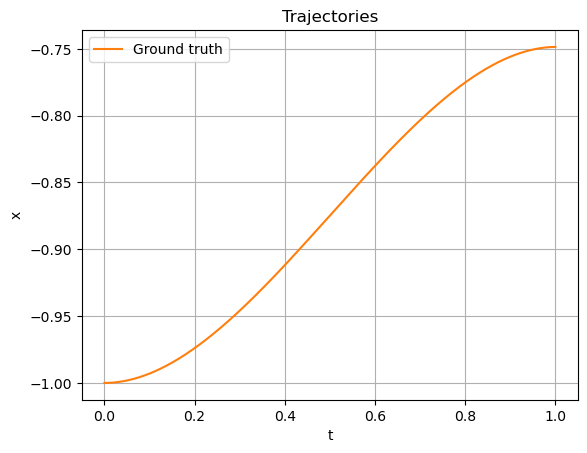

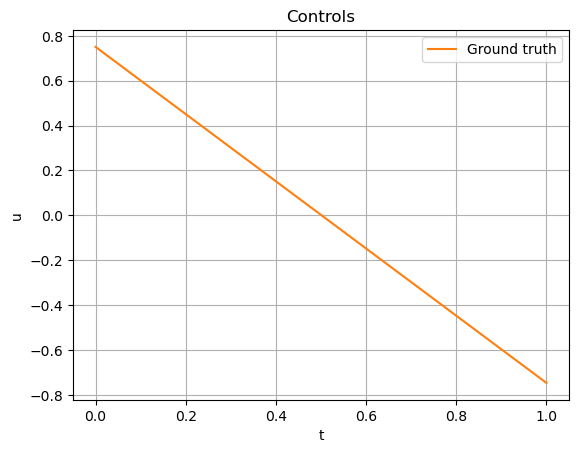

0.7485811988732496

In [2]:
gt_x, gt_x_dot, gt_u = ground_truth_sample(x_0=-1)
plot_trajectory(gt_x=gt_x)
plot_control(gt_u=gt_u)
# Approximation of the optimal cost
cost(gt_x, gt_x_dot, gt_u)

# Numerical discretization of the problem

Let's discretize the system in time; this discretization will be used to implement a simulator for the system of interest, but also to look for the control $u$ in a subset of all possible functions in the methods presented below.

Let $N \in \N^*$ be the discretization resolution and $\Delta t = \frac{T}{N}$ the time step. Let $\forall n \in \intset{0}{N}, \ t_n = n \Delta t, \ u_n = \mu(t_n)$, $x_n = x(t_n)$ and $v_n = \dot{x}(t_n)$. We also denote by $\mathbf{x}$, $\mathbf{v}$ and $\mathbf{u}$ the vectors $(x_0, ..., x_N)^\T$, $(v_0, ..., v_N)^\T$ and $(u_0, ..., u_{N-1})^\T$ .

With this discretization, we now _choose_ to search a control $\mu$ in a subset $\U_{\Delta t} \subset \U$, namely:
$$
    \U_{\Delta t} = \left\{ \left. \sum_{n=0}^{N-1} u_n \mathbb{1}_{[t_n, t_{n+1})} \ \right| \ \forall n \in \intset{0}{N}, u_n \in U \right\}.
$$

Moreover, we observe that for any $u \in \U_{\Delta t}$ and any $n \in \intset{0}{N-1}$:
$$
\begin{aligned}
    x_{n+1} &= x_n + \int_{t_n}^{t_{n+1}} \dot{x}(s) \d s\\
    &= x_n + \int_{t_n}^{t_{n+1}} \bigg( v_n + \int_{t_n}^s \ddot{x}(r) \d r \bigg) \d s\\
    &= x_n + \Delta t\,v_n + \int_{t_n}^{t_{n+1}} \bigg( \int_{t_n}^s \frac{u_n}{m} \d r \bigg) \d s\\
    &= x_n + \Delta t\,v_n + \frac{{\Delta t}^2}{2m} u_n
\end{aligned}
$$
and
$$
    v_{n+1} = v_n + \frac{\Delta t}{m} u_n.
$$

Furthermore, the cost function rewrites:
$$
    J(\mathbf{u}) = \lambda_P x_N^2 + \lambda_V v_N^2 + \Delta t \sum_{n=0}^{N-1} u_n^2.
$$

## Deriving a simulator

From this discretization, in `utils.py`, we define a simulator that will represent the system under scrutiny: we will use it to simulate the interactions with the system that arise in the various algorithms detailed below.

This simulator takes as argument a policy, which is a function of $x$ and/or $t$ that represents our control. It proceeds in a ``time-marching'' manner as it iteratively enforces the _dynamics_ $\P : \Omega \times \V \times U \to \Omega \times \V$ defined by:
$$
    \P(x, v, u)
     = \begin{pmatrix} \P_x(x, v, u) \\ \P_v(v, u) \end{pmatrix}
     =\begin{pmatrix} x + \Delta t\,v + \frac{{\Delta t}^2}{2m} u \\ v + \frac{\Delta t}{m} u \end{pmatrix}.
$$
In other words, this dynamics function takes as arguments a position $x$, a velocity $v$ and an action $u$ and returns the new position and velocity, computed by integrating $u$ (considered cosntant on the time interval) starting from $x$ and $v$.

At each time step, the simulator feeds the current state into the policy to generate an action that is passed to the dynamics; the latter outputs the new state that is used for the following step.
Lastly, the simulator outputs the trajectory, that is the array of positions at the end of each time interval.

# Short review of traditional methods

Let's now assume that we don't have an analytical solution. How can we solve this control problem? The classical, naive way would be to solve an inverse problem to fit a model and determine $m$ thereby. From there, we can use one of the traditional methods described below.

## Finding the model

Before applying control algorithms, we need to identify the mass $m$. This is an instance of a _system identification_ problem. This discipline consists in matching a theoretical model to a system that you want to control. Various methods exist depending on the level of knowledge of the system: full knowledge of the system (white box), no knowledge (black box) or partial knowledge (grey box). When a model is available, white box approaches are usually more efficient, but such models are usually very costly to find. This is why many applications actually resort to black box systems which leverage tools out-of-the box like the autoregressive models to find a structure for the model to identify. In particular, the NARMAX (Non-linear AutoRegressive Model with Average and eXogeneous input) model is widely used in the case of non-linear black boxes [@chen_narmax]. The NARMAX model is a very general model that comes in many variants depending on the basis of functions that is used for regression (polynomial, wavelets,...). This model involves a linear combination of parameters with factors that are non-linear combinations of the inputs and the outputs of the model; then, methods using such models are about choosing the correct degree of non-linearity and fitting the parameters to infer a model. But the number of parameters increases greatly wth the degree of nonlinearity, and fitting the data requires a lot of data and computations.

More recently, in the frame of "identification for control" approaches, the identification method is not necessarily chosen to get the most accurate model, but the one that finds the best balance between identification effort and control performance. This paradigm strengthens the appeal for data-driven techniques. Sometimes, it might even be convienient not to explicit any model, in a _model-free_ fashion, which we could achieve with RL.

Regardless of the method chosen, the identification process can be divided into 4 steps:

1. __Data gathering__ consists in collecting (ideally) input-output pairs (or only output samples if the system doesn't take inputs) that are representative of the system's behaviour. Inputs should be chosen in the widest range possible to explore the system well.

2. __Model postulate__ makes a guess for the mathematical structure of the model, that is the class of functions in which the model should be searched. In the case of a black-box approach, this structure should be as generic as possible, fox example with NARMAX.

3. __Parameter identification__ finetunes the parameters to particularize the identified model searched in the class of functions defined in the previous step.

4. __Model validation__ confirms that the identified system correspond to actual data, usually chosen differently from the data used for the indentification.

In our simple case, we already have a model structure well defined, so step 2 should be straightforward, and step 3 will consist in finding the correct mass $m$, which we will do by least squares regression.
Gathering data for steps 1 and 4 will be carried out using an analytical simulator implemented in the `utils.py` file.

### Data generation

Data is generated using the simulator. The trajectories returned by the latter will be used as samples, _i.e._ observations of the system for model identification. Note that we could have chosen a sampling time-step for the state different from that for the control, but it seems reasonable to assume that we are able to observe the state of the cart at the same pace as we adjust the force upon it.

In this simple case, sampling one trajectory for a constant action should be enough, and we can just apply a quadratic regression. Indeed, for a constant force $u$ and a known initial position $x_0$:
$$
    x(t) = \frac{u}{2m} t^2 + x_0
$$
So, we just need to determine the coefficient $a$ in the polynomial $x(t) = a t^2 + b t + c$.

In [3]:
x_0 = -0.9
t = np.linspace(0, 1, N+1)
u = 1
identification_data, _ = simulator(x_0, lambda t, x, v: u)
regression_polynomial = np.polyfit(t, identification_data, deg=2)
M_ESTIMATED = u/(2*regression_polynomial[0])
print("Polynomial obtained from the regression:", regression_polynomial)
print("Estimated mass:", M_ESTIMATED)

Polynomial obtained from the regression: [ 1.00000000e+00  9.36747757e-16 -9.00000000e-01]
Estimated mass: 0.5000000000000003


We see that we get the exact mass, up to the numerical errors. Here the process is very fast and simple because the model is very simple (we already know the mathematical structure of the model) and the simulator is noise-less.

[validation]

## Solving the optimal problem by gradient descent

[TO WRITE AGAIN]

In the literature, traditional methods for offline problems typically split into 3 categories:

1. Dynamic programming methods, for example integrating HJB equations backwards to get the value function and derive a control. These are very computationally expansive methods that are rarely used as-is (approximations are used, which is somewhat what we are doing with RL...).

2. Direct methods, in which the state equation is discretized in time and the state and/or the control are parameterized, so as to end up with a (usually high-dimensional but sparse) NLP problem that is solved with traditional solvers. These solvers might use computations of the gradient, that may be worked out using integrations of the adjoint state equation.

3. Indirect methods use the theory of calculus of variations and Pontryagin's minimum principle to derive a non-linear system to solve.

These methods can further be sub-divided into (in)direct shooting methods, in which better and better solutions are iteratively proposed and refined by trial and error, and (in)direct collocation methods, in which the control and/or the state is approximated by a class of parameterized functions. While the former approach usually implies "time-marching" to integrate the trajectory step by step, in the latter case, the problem reduces to an algebraic system to solve, so the trajectory at all time steps is solved "simultaneously".

Nowadays, direct methods are the most commonly used ones, because they reformulate the problem as an NLP problem for which many well established and efficient solvers exist. In other words, these methods are an easy way to move the problem to a well-known one. In particular, a good choice for problems involving smooth functions is the pseudospectral method, which is a global collocation method using an orthogonal basis of functions (such as Lagrange polynomials, Tchebischev polynomials...). 

Another common distinction for numerical control methods is that between discretize-then-control and control-then-discretize methods.

More thorough reviews of such methods exist in the literature, see for instance [@rao_classical_numerical_control] and [@biral_classical_numerical_control].

Lastly, other methods exist and are more suited to online problems, such as closed-loop controls like the MPC (Model Predictive Control) or the proportional–integral–derivative (PID) controller which are currently widely used in industry, but we won't implement such methods for this simple problem.

In what follows, we use the discretization in time from before to perform a gradient descent using the _scipy_ library on _Python_.

<!-- With the previous discretization, the problem rewrites as an NLP:
$$
    \min_{\x,\, \v,\, \u} \J(\x, \v, \u),
$$
where
$$
    \J(\x, \v, \u) = \lambda_P \x_N^2 + \lambda_V \v_N^2 + \Delta t \sum_{n=0}^{N-1} \u_n^2
$$
and subject to
$$
\begin{cases}
    \x_{n+1} = \x_n + \Delta t\,\v_n + \frac{{\Delta t}^2}{2m} \u_n & \forall n \in \intset{0}{N-1}\\
    \x_0 = x_0\\
    \v_{n+1} = \v_n + \frac{\Delta t}{m} \u_n & \forall n \in \intset{0}{N-1}\\
    \v_0 = 0\\
\end{cases}
$$

This is an NLP problem with $M = N*N*(N-1)$ variables. We will solve it using _IPOPT_. -->

For this simple problem, we can easily express $x$ and $\dot{x}$ in terms of the $u_k, k \in \intset{0}{n-1}$ and thus find the gradient of $J$ w.r.t. $u$. Therefore, we will here solve the problem using BFGS algorithm, as implemented in _scipy_.

We work out by hand that for all $t \in [0, T]$:
$$
\begin{cases}
    \displaystyle m \dot{x}(t) = \Delta t \sum_{k=0}^{N(t)-1} u_k + (t - t_{N(t)}) u_{N(t)}\\
    \displaystyle m x(t) = m x_0 + \sum_{n=0}^{N(t)-1} \sum_{k=0}^{n} {\Delta t}^2 u_k + \sum_{k=0}^{N(t)-1} \big( (t-t_{N(t)}) \Delta t \, u_k \big) + \frac{(t - t_{N(t)})^2}{2} u_{N(t)}
\end{cases}
$$
where $N(t) = \left\lfloor\frac{t}{T}\right\rfloor N$.

So,
$$
\begin{cases}
    \displaystyle v_N(\u) = \frac{\Delta t}{m} \sum_{k=0}^{N-1} u_k\\
    \displaystyle x_N(\u) = x_0 + \frac{{\Delta t}^2}{m}\sum_{n=0}^{N-1} \sum_{k=0}^{n} u_k = x_0 + \frac{{\Delta t}^2}{m}\sum_{n=0}^{N-1} (N - n) u_n.
\end{cases}
$$

Thus,
$$
\begin{cases}
    \displaystyle \nabla v_N(\u) = \frac{\Delta t}{m} \begin{pmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{pmatrix} \\
    \displaystyle \nabla x_N(\u) = \frac{{\Delta t}^2}{m} \begin{pmatrix} N \\ N-1 \\ \vdots \\ 1 \end{pmatrix},
\end{cases}
$$
hence
$$
\begin{cases}
    \displaystyle \nabla (v_N^2)(\u) = 2 \left( \frac{\Delta t}{m} \right)^2 \, \sum_{k=0}^{N-1} u_k \begin{pmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{pmatrix} \\
    \displaystyle \nabla (x_N^2)(\u) = 2 \frac{{\Delta t}^2}{m} \bigg( x_0 + \frac{{\Delta t}^2}{m}\sum_{n=0}^{N-1} (N - n) u_n \bigg) \begin{pmatrix} N \\ N-1 \\ \vdots \\ 1 \end{pmatrix}.
\end{cases}
$$


Finally,
$$
    \nabla J(\u) = 2 \lambda_P \frac{{\Delta t}^2}{m} \bigg( x_0 + \frac{{\Delta t}^2}{m}\sum_{n=0}^{N-1}  (N - n) u_n \bigg) \begin{pmatrix} N \\ N-1 \\ \vdots \\ 1 \end{pmatrix} + 2 \lambda_V \left( \frac{\Delta t}{m} \right)^2 \, \sum_{k=0}^{N-1} u_k \begin{pmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{pmatrix} + 2 \Delta t \u.
$$

In [4]:
def J(u, x_0, m):
    """Cost as a function of u and x_0, for a given mass m.

    :param np.ndarray[float] u: N-vector representing the discretized u.
    :param float x_0: Initial condition.
    :param float m: Estimation of the mass.
    :return float: The value of the cost function.
    """
    x_N = x_0 + DT**2/m * np.sum(np.arange(N, 0, -1)*u)
    v_N = DT/m * np.sum(u)
    return LAMBDA_P*x_N**2 + LAMBDA_V*v_N**2 + DT*np.sum(u**2)

def grad_J(u, x_0, m):
    """Gradient of the cost function w.r.t. $u$ evaluated in u, for an initial condition x_0.
    
    :param np.ndarray[float] u: N-vector representing the discretized u.
    :param float x_0: Initial condition.
    :param float m: Estimation of the mass.
    :return float: The gradient of the cost function.
    """
    grad_x_sq =  ( 2 * DT**2/m * (x_0 +  DT**2/m * np.sum(np.arange(N, 0, -1)*u)) ) * np.arange(N, 0, -1)
    grad_v_sq = ( 2 * (DT/m)**2 * np.sum(u) ) * np.ones(N)
    return LAMBDA_P*grad_x_sq + LAMBDA_V*grad_v_sq + 2*DT*u

Optimization terminated successfully.
         Current function value: 0.755520
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8


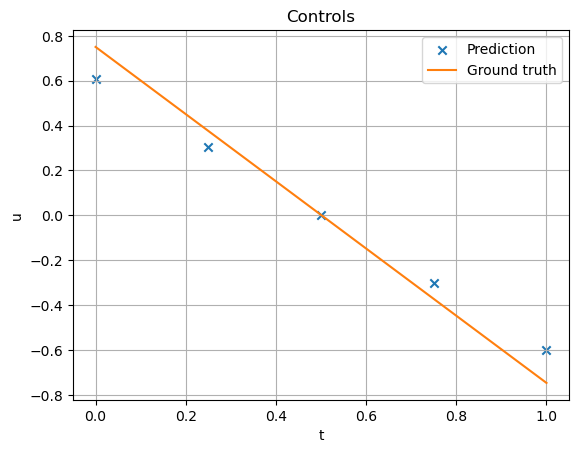

In [18]:
from scipy.optimize import minimize

def solve_by_bfgs(x_0, m):
    """Solves the control problem using BFGS, with initial condition x_0 and estimated mass m.
    
    :param float x_0: Initial condition.
    :param float m: Estimation of the mass.
    :return np.ndarray[float]: The optimal control.
    """
    res = minimize(lambda u: J(u, x_0, m), np.zeros(N), method='BFGS', jac=lambda u: grad_J(u, x_0, m), options={'disp': True})
    return res.x

x_0 = -1
bfgs_u = solve_by_bfgs(x_0, M_ESTIMATED)
gt_x, _, gt_u = ground_truth_sample(x_0=x_0)
plot_control(predicted_u=bfgs_u, gt_u=gt_u, T=T)

To visualize the associated trajectory, we can use the simulator. To do that, we need to define a policy from this predicted control.

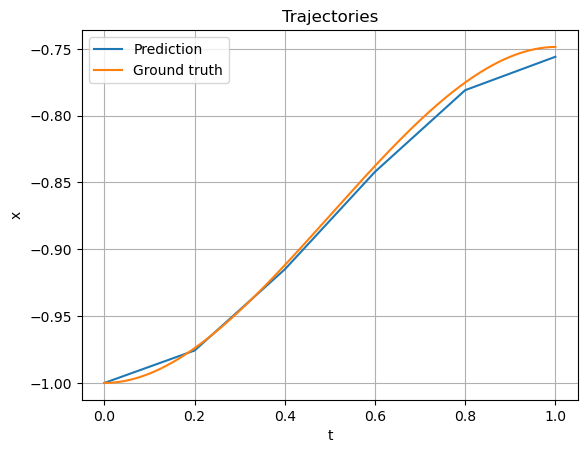

In [19]:
bfgs_policy = lambda t, x, v: bfgs_u[int(t/T*bfgs_u.shape[0])]
bfgs_x, _ = simulator(x_0, bfgs_policy)
plot_trajectory(bfgs_x, gt_x=gt_x)

The small discrepancy between the 2 results is mainly due to our very rough discretization in time and to the fact that the force is taken piece-wise constant. Taking a larger $N$ would give better results.

Note that for harder problems, expressing $x_N$ and $\dot{x}_N$ in terms of $u$ and derivating these expressions to derive an analytical gradient might be a much harder task. We could approximate this gradient by finite difference, but this would require to integrate the state equation in all directions of $\U_{\Delta t}$. Another possibility would be to consider the $x_n$ and $v_n$ as variables and add constraints to apply the numerical scheme. This would lead to an NLP that we could solve thanks to one of the numerous available NLP solvers, like _Ipopt_ [@wachter_ipopt]. But again, the number of variables would grow as 3 times the number of steps for the time discretization; for a PDE requiring a discretization in space, it would grow exponentially with the number of dimensions in space!

However, we can also compute this gradient by other means. The adjoint method is a common approach to compute the gradient of the cost function in terms of the state and costate trajectories. Let's illustrate this method for our example, starting with a small proof.

Remembering the formulation as an LQR, the cost writes:
$$
    J(\mu) = \int_0^T (\mu(t)^\T R\mu(t)) \dd t + X(T)^\T D X(T)
$$
with
$$
    R = 1 \quad and \quad D = \begin{pmatrix}
        \lambda_P & 0\\
        0 & \lambda_V
    \end{pmatrix}
$$
subject to:
$$
\begin{cases}
    \dot{X}(t) = A X(t) + B \mu(t) & \forall t \in [0, T],\\
    X(0) = (0, 0)^\T,
\end{cases}
$$
with
$$
    \forall t \in [0, T], \ X(t) = \begin{pmatrix}
        x(t)\\
        \dot{x}(t)
    \end{pmatrix}, \qquad
    A = \begin{pmatrix}
        0 & 1\\
        0 & 0
    \end{pmatrix} \quad and \quad
    B = \frac{1}{m} \begin{pmatrix}
        0\\
        1
    \end{pmatrix}
$$
We see that $J$ can be decomposed into $J = J_R + J_D$ with:
$$
    J_R = \lVert \mu \rVert_{L^2} \quad \text{and} \quad J_D = X(T)^\T D X(T)
$$
It is easily shown that $\nabla_\mu J_R = 2\mu$.

To compute the gradient of $J_{D}$, this time we want to avoid having to compute $\nabla_\mu X(T)$. Let's consider a small perturbation of te control $\delta\mu \in L^2([0, T], U)$ and let's introduce $X_{\mu + \delta \mu}$ associated to the control $\mu + \delta \mu$. Then, by linearity of the state equation:
$$
    X_{\mu + \delta\mu} = X_\mu + \delta X \quad \text{with} \quad \delta \dot{X} = A \delta X + B \delta \mu.
$$
So, since $D$ is symmetric:
$$
\begin{align*}
    J_D(\mu + \delta \mu) & = X_{\mu+\delta \mu} (T)^\T D X_{\mu+\delta \mu} (T)^{\T} \\
     & = X_\mu(T)^\T D X_\mu(T) + 2 X_\mu(T)^\T D\,\delta X(T) + \delta X(T)^\T D\,\delta X(T).
\end{align*}
$$
Now, by Duhamel's formula with $\delta X(0) = 0$:
$$
    \delta X(t) = \int_0^t e^{(t-s)A} B \delta \mu(s) \d s,
$$
hence $\lVert \delta X \rVert_{C^0} \leq C \rVert \delta \mu \rVert_{L^2}$ with $C$ a constant that does not depend on $\delta \mu$.

Furthermore, since
$
D=\begin{pmatrix}
    \lambda_P & 0 \\
    0 & \lambda_V
\end{pmatrix}$, then $\lvert \delta X(T)^\T D \delta X(T) \rvert^2 \leq \max(\lambda_P, \lambda_V)  \lvert \delta X(T) \rvert^2  \leq C \max(\lambda_P, \lambda_V)$. So, $\delta X(T)^\T D\,\delta X(T) = o(\delta \mu)$.

Therefore:
$$
\begin{align*}
    J_D(\mu + \delta \mu) & = J_D(\mu) + 2 X_\mu(T)^\T D\,\delta X(T) + o(\delta \mu),
\end{align*}
$$
hence $\forall \mu \in L^2([0, T], U)$,
$$
    \langle \nabla J_D(\mu), \delta \mu \rangle = 2 X_\mu(T)^\T D\,\delta X(T)
$$
Remembering the definition of the adjoint system for the LQR:
$$
\begin{cases}
    \dot{p}(t) = -A^\T p\\
    p(T) = D X_\mu(T),
\end{cases}
$$
we have:
$$
\begin{align*}
    \langle \nabla J_{D}(p), \delta \mu \rangle & = 2 \delta X(T)^\T p(T)\\
     & = 2 [\delta X(t)^\T p(t)]_0^T\\
     & = 2 \int_0^T \frac{\d}{\d t}\big(\delta X(t)^\T p(t)\big) \d t\\
     & = 2 \int_0^T \big[\dot{\delta X}(t)^\T p(t) + \delta X(t)^\T \dot{p}(t) \big] \d t\\
     & = 2 \int_0^T \big[(A \delta X(t) + B \delta \mu(t))^\T p(t) - \delta X(t)^\T A^\T p(t) \big] \d t\\
     & = 2 \int_0^T \delta \mu(t)^\T B^\T p(t)\,\d t\\
     & = \langle 2 B^\T p, \delta \mu \rangle
\end{align*}
$$
Therefore, the gradient of $J$ is:
$$
    \boxed{\nabla J(\mu) = 2 \mu + 2 B^\T p}
$$
We just obtained an expression of the gradient that doesn't need to compute the gradient of $X(t)$ w.r.t. $\mu$, but this computation requires to integrate the state ODE (to get $p(T)$) and the adjoint ODE to compute $p$. For higher dimensions, this could be quite costly, but not as much as approximating the gradient by finite difference.

To get the state and adjoint state trajectories, let's use the Euler integration scheme. For the state trajectory:
$$
\begin{align*}
    X_{n+1} & = X_n + \int_{t_n}^{t_{n+1}} \big( A X(t) + B \mu(t) \big) \d t \\
     & \approx X_n + \Delta t \big( A X_n(t) + B u_n \big).
\end{align*}
$$

Likewise, denoting $\forall n \in \intset{0}{N}, \ p_n = p(t_n)$:
$$
\begin{align*}
    p_{n+1} & = p_n - \int_{t_n}^{t_{n+1}} A^\T p(t) \d t \\
     & \approx p_n - \Delta t A^\T p_{n+1},
\end{align*}
$$
so:
$$
    p_n \approx p_{n+1} + \Delta t A^\T p_{n+1}.
$$

In [20]:
def euler_simulator(x_0, u, m, dt=DT):
    """Compute the trajectory using explicit Euler method.

    :param float x_0: Initial condition on x.
    :param np.ndarray[float] u: N-vector representing the discretized control.
    :param float m: Estimation of the mass of the cart.
    :param float dt: Integration time between two samples for the Euler method.
    :return: The state trajectory X.
    :rtype: np.ndarray[float] of dimension (T/dt, 2).
    """
    n_samples = int(T/dt)
    X = np.zeros((n_samples+1, 2))
    A = np.array([[0, 1], [0, 0]])
    B = 1/m * np.array([[0], [1]])
    u = np.expand_dims(u, axis=-1)
    X[0, 0] = x_0
    for n in range(n_samples):
        X[n+1] = X[n] + dt*(A@X[n] + B@u[n])
    return X

def euler_adjoint_simulator(p_T, dt=DT):
    """Compute the adjoint trajectory using backward Euler method.

    :param float p_T: Terminal condition on p.
    :param float dt: Integration time between two samples.
    :return: The adjoint trajectory p.
    :rtype: np.ndarray[float] of dimension (T/dt, 2).
    """
    n_samples = int(T/dt)
    p = np.zeros((n_samples+1, 2))
    A_T = np.array([[0, 0], [1, 0]])
    p[-1] = p_T
    for n in range(n_samples-1, -1, -1):
        p[n] = p[n+1] + dt*A_T@p[n+1]
    return p

def grad_J_adjoint(u, x_0, m, dt=DT):
    """Gradient of the cost function w.r.t. $u$ evaluated in u, for an initial condition x_0, using the adjoint method.
    
    :param np.ndarray[float] u: N-vector representing the discretized control.
    :param float x_0: Initial condition on x.
    :param float m: Estimation of the mass.
    :param float dt: Integration time between two samples for the integration of p.
    :return float: The gradient of the cost function.
    """
    B = 1/m * np.array([[0], [1]])
    D = np.array([[LAMBDA_P, 0], [0, LAMBDA_V]])
    X = euler_simulator(x_0, u, m, dt=dt)
    p = euler_adjoint_simulator(D@X[-1])
    return 2*u + 2*np.dot(B.T, p.T)[0, :-1]

         Current function value: 0.755520
         Iterations: 22
         Function evaluations: 90
         Gradient evaluations: 78


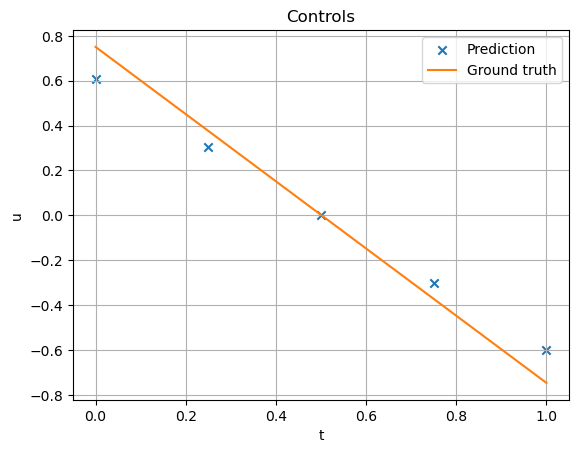

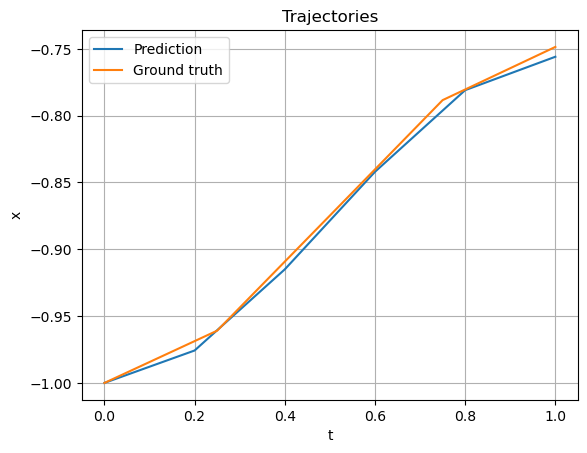

Comparison with previous computation of the gradient:
Optimization terminated successfully.
         Current function value: 0.755520
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8


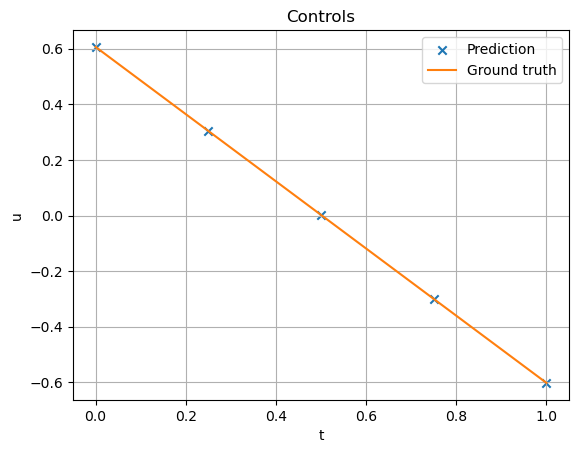

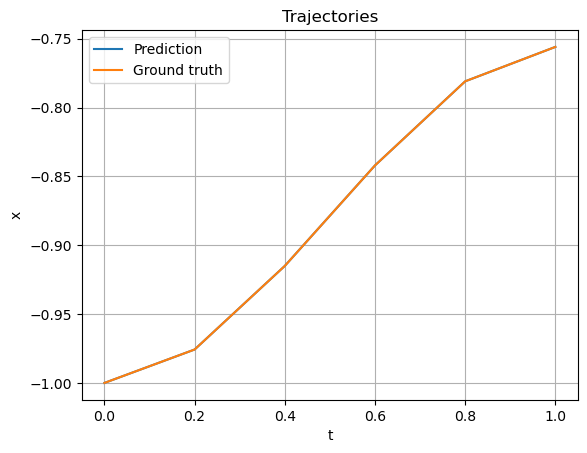

In [21]:
def solve_by_bfgs_adjoint_method(x_0, m):
    """Solves the control problem using BFGS, with initial condition x_0 and estimated mass m, and using the adjoint method to compute the gradient of J.
    
    :param float x_0: Initial condition.
    :param float m: Estimation of the mass.
    :return np.ndarray[float]: The optimal control.
    """
    res = minimize(lambda u: J(u, x_0, m), np.zeros(N), method='BFGS', jac=lambda u: grad_J_adjoint(u, x_0, m), options={'disp': True})
    return res.x

x_0 = -1

adjoint_bfgs_u = solve_by_bfgs_adjoint_method(x_0, M_ESTIMATED)
gt_x, _, gt_u = ground_truth_sample(x_0=x_0, res=N)
plot_control(predicted_u=adjoint_bfgs_u, gt_u=gt_u, T=T)
adjoint_bfgs_policy = lambda t, x, v: adjoint_bfgs_u[int(t/T*adjoint_bfgs_u.shape[0])]
adjoint_bfgs_x, _ = simulator(x_0, adjoint_bfgs_policy)
plot_trajectory(adjoint_bfgs_x, gt_x=gt_x)

print("Comparison with previous computation of the gradient:")
bfgs_u = solve_by_bfgs(x_0, M_ESTIMATED)
plot_control(predicted_u=adjoint_bfgs_u, gt_u=bfgs_u, T=T)
bfgs_policy = lambda t, x, v: bfgs_u[int(t/T*bfgs_u.shape[0])]
bfgs_x, _ = simulator(x_0, bfgs_policy)
plot_trajectory(bfgs_x, gt_x=bfgs_x)

# Solving by dynamic programming

Before moving to the RL implementation, let's illustrate that this problem can be solved exactly by dynamic programming (DP).
To that aim, since we will be using discrete DP here, we need discrete states, so we need not only to discretize the problem in time, but also in space, velocity and action.

For consistency, we choose the same discretization in time as for the integration of the state ODE.

As for the action space, we arbitrarily restrain $U$ to $\tilde{U} = [U_l, U_r]$ (with $U_l \in \mathbb{Z}^-$ and $U_r \in \mathbb{Z}^+$) and $\U$ to $\tilde{\U} = L^1\big( [0, T],  \tilde{U} \big)$. Since the velocity will also be part of the state, we also need to restrain it. We do so to $\tilde{\V} = [\V_l, \V_r] = [\frac{U_l}{m}\,T, \frac{U_r}{m}\,T]$ which is a natural choice because it is the set $E(T) = \{v \in \R | \exists u \in \tilde{\U}, \ \dot{x_u}(T) = v \} $ of reachable velocities from $0$ and in time $T$.

Let's introduce $N_\V$ and $N_U$ the discretization resolutions for $\tilde{\V}$ and $\tilde{U}$, and $\Delta v = \frac{1}{N_\V}$ and $\Delta u = \frac{1}{N_U}$. For consistency, if we want the minimal gap between 2 discretized velocities to coincide with the minimal possible step taken by the system, we should choose $\Delta v = \P_v(v, \Delta u) - v = \frac{\Delta u}{m}\Delta t$ (where $v$ is some vector of $\V$).

Likewise, we restrain the position to $\tilde{\Omega} = [\Omega_l, \Omega_r] = [-1 + \frac{U_l}{2m}\,T^2, \frac{U_r}{2m}\,T^2]$, and we define $\Delta x = \min\left\{\P_x(x, k_v \Delta v, k_u \Delta u) - x \right| \left. k_v \in \mathbb{Z}, \ k_u \in \mathbb{Z}, \ \P_x(x, k_v \Delta v, k_u \Delta u) - x \neq 0 \right\} = \P_x(x, 0, \Delta u) - x = \frac{{\Delta t}^2}{2 m} \Delta u$ (where $x$ is some vector of $\Omega$) and $N_\Omega = \frac{1}{\Delta x}$.

We now look for $u$ in
$$
    \tilde{\U}_{\Delta t, \Delta u} = \left\{ \left. \sum_{n=0}^{N-1} u_n \mathbb{1}_{[t_n, t_{n+1})} \ \right| \ \forall n \in \intset{0}{N}, u_n \in \tilde{U}_{\Delta u} \right\},
$$
where
$$
    \tilde{U}_{\Delta u} = \{U_l, U_l + \Delta u, ..., U_r\}
$$
(so $|\tilde{U}_{\Delta u}| = (U_r - U_l)N_U + 1$).

Likewise, the $v_n, \ n \in \intset{0}{N}$, will be confined in:
$$
    \tilde{\V}_{\Delta v} = \{ \V_l, \V_l + \Delta v, ..., \V_r \}
$$
(so $|\tilde{\V}_{\Delta v}| = (\V_r - \V_l)N_\V + 1$), and for a correctly truncated $x_0$, with our choice of $\tilde{\U}_{\Delta t, \Delta u}$, the $x_n, \ n \in \intset{0}{N}$, will be confined in:
$$
    \tilde{\Omega}_{\Delta x} = \{ \Omega_l, \Omega_l + \Delta x, ..., \Omega_r \}
$$
(so $|\tilde{\Omega}_{\Delta x}| = (\Omega_r - \Omega_l)N_\Omega + 1$).

The minimization problem is now:
$$
    \min_{(u_n)_{n\in \{0, ..., N-1\}} \in (U_{\Delta u})^N} \lambda_P x_N^2 + \lambda_V v_N^2 + \Delta t \sum_{n=0}^{N-1} u_n^2.
$$

For coding reasons, we also need the state and the action to be integers that can be interpreted as indices for an array. So, the position, velocity and action will live in:
$$
    \tilde{\Omega}_{\Delta x}^{arr} = \{ 0, \Delta x, ..., (\Omega_r - \Omega_l) N_\Omega \Delta x \},
$$
$$
    \tilde{\V}_{\Delta v}^{arr} = \{ 0, \Delta v, ..., (\V_r - \V_l) N_\V \Delta v \}
$$
and
$$
    \tilde{U}_{\Delta u}^{arr} = \{ 0, \Delta u, ..., (U_r - U_l) N_U \Delta u \}
$$
respectively. We define functions to easily switch from one representation to another, namely the $\phi_{z \to z^{arr}}$ to go from $\tilde{Z}_{\Delta z}$ to $\tilde{Z}_{\Delta z}^{arr}$ where $z$ denotes $x$, $v$ or $u$ and $Z$ denotes $\Omega$, $\V$ or $U$. We also define their inverses $\phi_{z^{arr} \to z}$.

From there, we suggest the following DP formulation of the problem:
- state space: $S = \tilde{\Omega}_{\Delta x} \times \tilde{\V}_{\Delta v}$. A state is $s=(x, v) \in S$ and represents the position of the cart and its velocity at a given time step.
- action space $A = \tilde{U}_{\Delta u} $. An action is $a \in A$ and is a representation of the control $u$ at a given time step.
- Dynamics: $P$.
- running reward function: $\forall n \in \intset{0}{N-1}, \ r_n(s, a) \equiv r(s, a) = -\Delta t \, a_n^2$.
- final reward function: $r_N(x_N, v_N) = \lambda_P x_N^2 + \lambda_V v_N^2 $.

Note that since the problem is of finite time-horizon, the value function $V$ and the policy $\pi$ will also depend on time.

Before diving into the implementation, let's take a look at the complexity of the DP algorithm in this case. Define an elementary operation as either computing a transition (next state and running reward) or accessing a value in an array like $V$. Then the complexity is in $\mathcal{O}(T \times |S| \times |A|)$. Now, $|S| = |\tilde{\Omega}_{\Delta x}| |\tilde{\V}_{\Delta v}|$ where $|\tilde{\V}_{\Delta v}| = \mathcal{O} \big( (\frac{U_r}{m} \, T - \frac{U_l}{m} \, T) N N_U \big)$ and $|\tilde{\Omega}_{\Delta x}| = \mathcal{O} \big( (\frac{U_r}{2m} \, T^2 - \frac{U_l}{2m} \, T^2) N^2 N_U \big)$, so $|S| = \mathcal{O} \big( \frac{(U_r - U_l)^2}{2m^2} T^3 N^3 {N_U}^2 \big)$.

Therefore, the complexity is in $\mathcal{O}\big( \frac{(U_r - U_l)^3}{2m^2} T^4 N^3 {N_U}^3 \big)$.

In [9]:
def  running_cost(x_n, v_n, a_n):
    """Running cost for the dynamic programming formulation.
    
    :param float x_n: Current position.
    :param float v_n: Current velocity.
    :param float a_n: Action taken.
    :return float: Running cost.
    """
    return DT*a_n**2

def  final_cost(x_N, v_N):
    """Final cost for the dynamic programming formulation.
    
    :param float x_n: Final position.
    :param float v_n: Final velocity.
    :return float: Final cost.
    """
    return LAMBDA_P*x_N**2 + LAMBDA_V*v_N**2

def reachable_x(t):
    """Returns the set of positions that are reachable in time t from x_0 varying in [-1, 0].
    This will be useful in dynamic programming for computing the value function only on relevant states.

    :param t float: This function computes positions that can be reached in time t.
    :return np.ndarray[float]: The array of positions that can be reached in time t.
    """
    return np.arange(-1 + U_L*(t**2)/(2*M_REAL), U_R*(t**2)/(2*M_REAL) + DX, DX)

def reachable_v(t):
    """Returns the set of velocities that are reachable in time t from a null velocity at time 0.
    This will be useful in dynamic programming for computing the value function only on relevant states.

    :param t float: This function computes velocities that can be reached in time t.
    :return np.ndarray[float]: The array of positions that can be reached in time t.
    """
    return np.arange(U_L/M_REAL*t, U_R/M_REAL*t + DV, DV)

In [10]:
# Solve by DP
X_size = int((X_R - X_L)*N_X)+1
V_size = int((V_R - V_L)*N_V)+1
U_size = int((U_R - U_L)*N_U)+1

action_space = np.arange(U_L, U_R+DU, DU)
V = np.inf*np.ones((N+1, X_size, V_size))
optimal_policy_array = np.inf*np.ones((N, X_size, V_size))
for x in reachable_x(T):
    for v in reachable_v(T):
        V[-1, to_arr_x(x), to_arr_v(v)] = final_cost(x, v) 
for n in range(N-1, -1, -1):
    for x in reachable_x(n*DT):
        for v in reachable_v(n*DT):
            costs = np.array([running_cost(x, v, a) for a in action_space])
            next_Vs = np.array([V[n+1, to_arr_x(x_new), to_arr_v(v_new)] for a in action_space for (x_new, v_new) in [dynamics(x, v, a)]])
            optimal_a_arr = np.argmin(costs + next_Vs)
            V[n, to_arr_x(x), to_arr_v(v)] = costs[optimal_a_arr] + next_Vs[optimal_a_arr]
            optimal_policy_array[n, to_arr_x(x), to_arr_v(v)] = from_arr_a(optimal_a_arr)
optimal_policy = lambda t, x, v: optimal_policy_array[round(t/DT), to_arr_x(x), to_arr_v(v)]

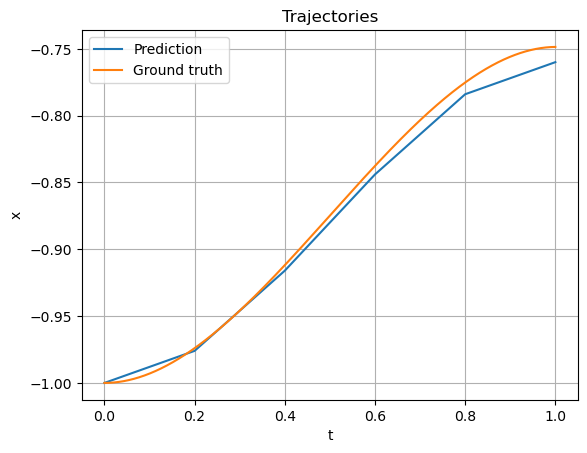

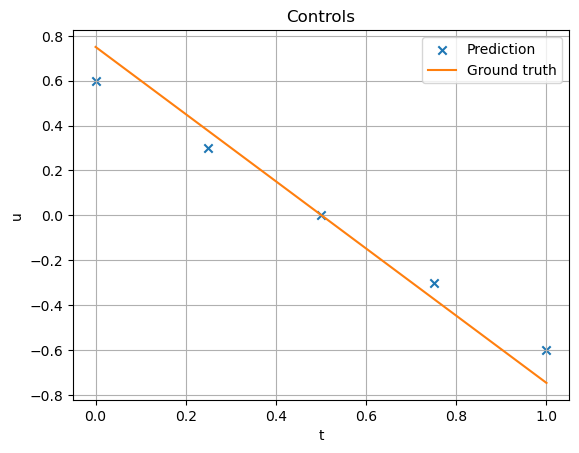

In [22]:
# Visualize DP solution
x_0=-1
dp_x, dp_u = simulator(x_0, policy=optimal_policy)
gt_x, _, gt_u = ground_truth_sample(x_0)
plot_trajectory(predicted_x=dp_x, gt_x=gt_x)
plot_control(predicted_u=dp_u, gt_u=gt_u)

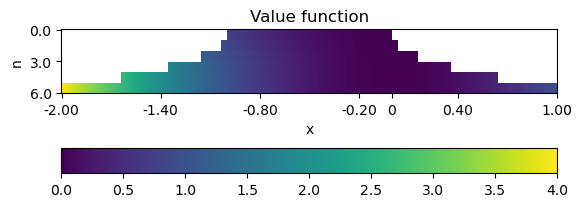

In [13]:
# Visualize V
plot_V_x(V, v=0, zoom_time=5)

We get similar results as for the 2 previous methods, with the same discrepancy due to our rough time discretization. Note that the problem is solved in reasonable time for this rough choice of parameters, but finer discretization steps might lead to exploding running times, and this is due to the curse of dimensionality well observed on the complexity computed above. Indeed, here the state has 2 dimensions, that of position and that of velocity, and the resolution of these dimensions is based on that of the action according to our discretization scheme. If the position space was of to dimensions (_e.g._ if our cart could move in a plane), the resulting complexity would be much worse!

In [ ]:
# Introduce the RL method used, justify that it is adapted to the problem

In [ ]:
# Solve by RL

In [ ]:
# Comment on the benefits, the differences with traditional methods...

In [ ]:
# Introduce variants of the problem (different mass) and motivate Transfer Learning

In [ ]:
# Does the agent perform well on variants of the problem?

In [ ]:
# Solve by Transfer Learning

# Bibliography